In [ ]:
from performance_model_dataset import *

In [3]:
from create_data import load_data

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Dict, Tuple, List

### Load Data from disk

In [5]:
data = load_data("output", ["EPL"])
EPL_Data = data["EPL"]

Loading data for EPL from ['2014', '2022', '2023', '2015', '2017', '2019', '2021', '2020', '2018', '2016']
Loading data for EPL from 2014
Loading data for EPL from 2022
Loading data for EPL from 2023
Loading data for EPL from 2015
Loading data for EPL from 2017
Loading data for EPL from 2019
Loading data for EPL from 2021
Loading data for EPL from 2020
Loading data for EPL from 2018
Loading data for EPL from 2016


### Data processing functions

In [6]:
def matches_data(Leage_Data):
    swap_counts = 0
    precision_errors = 0
    errors = []

    matches_data = {}

    for year in Leage_Data.keys():
        matches_df = Leage_Data[year]["data_ext"]
        # Iterate through each match in the dataframe
        for _, match in matches_df.iterrows():
            match_id = match["Match ID"]

            # Get team names
            home_team_name = match["Home"].replace(" ", "_")
            away_team_name = match["Away"].replace(" ", "_")

            # Get team IDs from the dataframe
            home_team_id = match[
                "Home Short"
            ]  # Assuming "Home Short" is used as the team ID
            away_team_id = match[
                "Away Short"
            ]  # Assuming "Away Short" is used as the team ID

            # Initialize the match entry in the dictionary

            # match (extended_data) keys
            # Index(['Match ID', 'Date', 'Home', 'Home Short', 'Away', 'Away Short',
            #   'Home Goals', 'Away Goals', 'Home xG', 'Away xG', 'Home Shots',
            #   'Away Shots', 'Home Shots on Target', 'Away Shots on Target',
            #   'Home Deep', 'Away Deep', 'Away PPDA', 'Home PPDA'],
            #  dtype='object')

            # roster summary keys
            #  Index(['Home Goals', 'Home Own Goals', 'Home Shots', 'Home xG', 'Home Time',
            #   'Home Yellow Card', 'Home Red Card', 'Home Key Passes', 'Home Assists',
            #   'Home xA', 'Home xGChain', 'Home xGBuildup', 'Away Goals',
            #   'Away Own Goals', 'Away Shots', 'Away xG', 'Away Time',
            #   'Away Yellow Card', 'Away Red Card', 'Away Key Passes', 'Away Assists',
            #   'Away xA', 'Away xGChain', 'Away xGBuildup', 'Season', 'Match ID',
            #   'League'],
            #  dtype='object')

            matches_data[match_id] = {
                "extended_data": match,
                "date": match["Date"],
                "home_team": {
                    "team_name": home_team_name,
                    "team_id": home_team_id,
                    "players": {},
                },
                "away_team": {
                    "team_name": away_team_name,
                    "team_id": away_team_id,
                    "players": {},
                },
                "roster": {},
                "roster_summary": {},
                "shots": {},
                "data_errors": 0,
                "full_data": None,
            }

            # Find the corresponding match in Leage_Data[year]["matches"]
            match_detail = next(
                (m for m in Leage_Data[year]["matches"] if m["match_id"] == match_id),
                None,
            )

            home_team = next(
                (
                    team
                    for team in Leage_Data[year]["teams"]
                    if team["team_name"] == home_team_name
                ),
                None,
            )

            away_team = next(
                (
                    team
                    for team in Leage_Data[year]["teams"]
                    if team["team_name"] == away_team_name
                ),
                None,
            )

            if not home_team or not away_team:
                # print(f"Team {home_team_name} or {away_team_name} not found")
                matches_data.pop(match_id)
                continue

            if match_detail:
                # Add roster summary and shots to the match data
                matches_data[match_id]["roster_summary"] = match_detail.get(
                    "rosters_summary", {}
                )
                matches_data[match_id]["shots"] = match_detail.get("shots", {})
                matches_data[match_id]["roster"] = match_detail.get("rosters", {})

                # Process home team players
                # print(match_detail["rosters"].keys())
                # print(match_detail["rosters"]["Home/Away"].value_counts())
                # break

                home_team_players = match_detail["rosters"][
                    match_detail["rosters"]["Home/Away"] == "h"
                ]

                for _, player_in_roster in home_team_players.iterrows():
                    player_id = player_in_roster["Player ID"]

                    # print(home_team["players"][0].keys())
                    # print([player["player_id"] for player in home_team["players"]])
                    # print(player_id)
                    player_obj = next(
                        (
                            player
                            for player in home_team["players"]
                            if player["player_id"] == str(player_id)
                        ),
                        None,
                    )

                    if not player_obj:
                        # print(f"Player {player_id} not found in team {home_team_name}")
                        continue
                    # print(player_obj.keys())
                    # [season for season in Haaland["groups"]["season"] if season["season"] == year][0]
                    player_season = next(
                        (
                            season
                            for season in player_obj["groups"]["season"]
                            if season["season"] == year
                        ),
                        None,
                    )

                    matches_data[match_id]["home_team"]["players"][player_id] = {
                        "player_name": player_in_roster["Player"],
                        "player_roster": player_in_roster,
                        "player_season": player_season,
                    }

                # Process away team players
                away_team_players = match_detail["rosters"][
                    match_detail["rosters"]["Home/Away"] == "a"
                ]

                for _, player_in_roster in away_team_players.iterrows():
                    player_id = player_in_roster["Player ID"]

                    # print([player["player_id"] for player in away_team["players"]])
                    # print(player_id)

                    player_obj = next(
                        (
                            player
                            for player in away_team["players"]
                            if player["player_id"] == str(player_id)
                        ),
                        None,
                    )

                    if not player_obj:
                        # print(f"Player {player_id} not found in team {away_team_name}")
                        continue

                    player_season = next(
                        (
                            season
                            for season in player_obj["groups"]["season"]
                            if season["season"] == year
                        ),
                        None,
                    )

                    matches_data[match_id]["away_team"]["players"][player_id] = {
                        "player_name": player_in_roster["Player"],
                        "player_roster": player_in_roster,
                        "player_season": player_season,
                    }

                # Check if the cols that are in the match ext data and in the roster summary have the same values
                for col in match.keys():
                    if col in matches_data[match_id]["roster_summary"].keys():
                        if (
                            match[col]
                            != matches_data[match_id]["roster_summary"][col][0]
                        ):
                            if col.startswith("Home") or col.startswith("Away"):
                                # Invertir los valores
                                col_suffix = col.split(" ", 1)[1]
                                if col.startswith("Home"):
                                    col_alt = f"Away {col_suffix}"
                                else:
                                    col_alt = f"Home {col_suffix}"

                                error_type = 0

                                def is_numeric(value):
                                    try:
                                        float(value)
                                        return True
                                    except ValueError:
                                        return False

                                if is_numeric(match[col]) and is_numeric(
                                    matches_data[match_id]["roster_summary"][col_alt][0]
                                ):
                                    match_value = float(match[col])
                                    roster_value = float(
                                        matches_data[match_id]["roster_summary"][
                                            col_alt
                                        ][0]
                                    )
                                else:
                                    match_value = match[col]
                                    roster_value = matches_data[match_id][
                                        "roster_summary"
                                    ][col_alt][0]

                                if is_numeric(match[col_alt]) and is_numeric(
                                    matches_data[match_id]["roster_summary"][col][0]
                                ):
                                    match_value_alt = float(match[col_alt])
                                    roster_value_alt = float(
                                        matches_data[match_id]["roster_summary"][col][0]
                                    )
                                else:
                                    match_value_alt = match[col_alt]
                                    roster_value_alt = matches_data[match_id][
                                        "roster_summary"
                                    ][col][0]

                                decimal_places = 1
                                if match_value != roster_value:
                                    if round(match_value, decimal_places) == round(
                                        roster_value, decimal_places
                                    ):
                                        precision_errors += 1
                                        # Keep the value with more precision
                                        if len(str(match_value).split(".")[1]) > len(
                                            str(roster_value).split(".")[1]
                                        ):
                                            roster_value = match_value
                                        else:
                                            match_value = roster_value
                                    elif round(match_value, decimal_places) == round(
                                        roster_value_alt, decimal_places
                                    ):
                                        swap_counts += 1
                                        # Keep the value with more precision
                                        if len(str(match_value).split(".")[1]) > len(
                                            str(roster_value_alt).split(".")[1]
                                        ):
                                            roster_value_alt = match_value
                                        else:
                                            match_value = roster_value_alt
                                    else:
                                        # print(
                                        #     f"{match_value} - {roster_value} | {match_value_alt} - {roster_value_alt}"
                                        # )
                                        matches_data[match_id]["data_errors"] += 1
                                        # in case of error
                                        errors.append(1)

                                if match_value_alt != roster_value_alt:
                                    if round(match_value_alt, decimal_places) == round(
                                        roster_value_alt, decimal_places
                                    ):
                                        precision_errors += 1
                                        # Keep the value with more precision
                                        if len(
                                            str(match_value_alt).split(".")[1]
                                        ) > len(str(roster_value_alt).split(".")[1]):
                                            roster_value_alt = match_value_alt
                                        else:
                                            match_value_alt = roster_value_alt
                                    elif round(
                                        match_value_alt, decimal_places
                                    ) == round(roster_value, decimal_places):
                                        swap_counts += 1
                                        # Keep the value with more precision
                                        if len(
                                            str(match_value_alt).split(".")[1]
                                        ) > len(str(roster_value).split(".")[1]):
                                            roster_value = match_value_alt
                                        else:
                                            match_value_alt = roster_value
                                    else:
                                        # print(
                                        #     f"{match_value_alt} - {roster_value_alt} | {match_value} - {roster_value}"
                                        # )
                                        matches_data[match_id]["data_errors"] += 1
                                        errors.append(2)
                            else:

                                errors.append(3)

                # intersect the match ext data with the match roster summary
                # print("Setting full data", match_id)
                matches_data[match_id]["full_data"] = pd.DataFrame(
                    {
                        **match,
                        **matches_data[match_id]["roster_summary"],
                    },
                    index=[0],
                )

                matches_data[match_id]["full_data"]["Date"] = pd.to_datetime(
                    matches_data[match_id]["full_data"]["Date"]
                )

    return matches_data

In [7]:
# cache lr
from functools import lru_cache


class HashableDict(dict):

    def __hash__(self):
        return hash(frozenset(self.items()))

    # def __eq__(self, other):
    #     if isinstance(other, HashableDict):
    #         return frozenset(self.items()) == frozenset(other.items())
    #     return False


from typing import Dict, List, Tuple, TypeVar

# HashableDict = TypeVar("HashableDict", bound=Dict)

# @lru_cache(maxsize=None)
def preprocess_matches(
    # matches_data_full: Dict[str, Dict]
    # matches_data_full: HashableDictT
    matches_data_full
) -> Tuple[Dict[str, List[pd.DataFrame]], Dict[Tuple[str, str], List[pd.DataFrame]]]:
    # Preprocess to get all matches by team and all matches between specific teams
    team_matches = {}
    team_vs_team_matches = {}

    for match_id, match in matches_data_full.items():
        match_data = match["full_data"]
        if match_data is None:
            continue

        home_team = match_data.iloc[0]["Home"]
        away_team = match_data.iloc[0]["Away"]

        # Store matches by team
        if home_team not in team_matches:
            team_matches[home_team] = []
        if away_team not in team_matches:
            team_matches[away_team] = []

        team_matches[home_team].append(match)
        team_matches[away_team].append(match)

        # Store matches between the two teams
        matchup_key = (
            (home_team, away_team) if home_team < away_team else (away_team, home_team)
        )
        if matchup_key not in team_vs_team_matches:
            team_vs_team_matches[matchup_key] = []
        team_vs_team_matches[matchup_key].append(match)

    return team_matches, team_vs_team_matches

def create_dataset(matches_data_full: Dict[str, Dict], prev_n=5, exclude_years= []) -> Tuple[np.ndarray, np.ndarray]:
    # Preprocess data
    team_matches, team_vs_team_matches = preprocess_matches(
        # HashableDict(matches_data_full)
        matches_data_full
    )

    X, y = [], []
    none_full_data = 0

    for match_id, match in tqdm(
        matches_data_full.items(), total=len(matches_data_full)
    ):
        match_data = match["full_data"]
        if match_data is None:
            none_full_data += 1
            continue

        home_team = match_data.iloc[0]["Home"]
        away_team = match_data.iloc[0]["Away"]
        home_goals = match_data.iloc[0]["Home Goals"]
        away_goals = match_data.iloc[0]["Away Goals"]

        match_date = match["date"]

        if pd.to_datetime(match_date).year in exclude_years:
            continue

        # Get previous matches for home and away teams
        prev_home_matches = [
            m["full_data"] for m in team_matches[home_team] if m["date"] < match_date
        ]
        prev_away_matches = [
            m["full_data"] for m in team_matches[away_team] if m["date"] < match_date
        ]

        # if len(prev_home_matches) < 5 or len(prev_away_matches) < 5:
        # continue

        # Get last 5 matches for both teams
        prev_home_matches = sorted(
            prev_home_matches, key=lambda x: x.iloc[0]["Date"], reverse=True
        )[:prev_n]

        prev_away_matches = sorted(
            prev_away_matches, key=lambda x: x.iloc[0]["Date"], reverse=True
        )[:prev_n]

        # Get previous matches between the two teams
        matchup_key = (
            (home_team, away_team) if home_team < away_team else (away_team, home_team)
        )

        prev_matches_between_teams = [
            m["full_data"]
            for m in team_vs_team_matches[matchup_key]
            if m["date"] < match_date
        ]

        if len(prev_matches_between_teams) == 0:
            continue

        # sort by date, newest first

        prev_home_matches = list(sorted(
            prev_home_matches, key=lambda x: x.iloc[0]["Date"], reverse=True
        ))

        prev_away_matches = list(sorted(
            prev_away_matches, key=lambda x: x.iloc[0]["Date"], reverse=True
        ))

        prev_matches_between_teams = list(sorted(
            prev_matches_between_teams, key=lambda x: x.iloc[0]["Date"], reverse=True
        ))

        def create_zeros_df():
            df = pd.DataFrame(
                # np.zeros((1, prev_matches_between_teams[0].shape[1]), dtype=int),
                np.empty((1, prev_matches_between_teams[0].shape[1]), dtype=int),
                columns=prev_matches_between_teams[0].columns,
            )
            df["Date"] = pd.to_datetime("1900-01-01")
            return df

        # if len(prev_home_matches) < prev_n:
        #     # fill with zeros
        #     prev_home_matches += [
        #         create_zeros_df()
        #         for _ in range(prev_n - len(prev_home_matches))
        #     ]

        # if len(prev_away_matches) < prev_n:
        #     # fill with zeros
        #     prev_away_matches += [
        #         create_zeros_df()
        #         for _ in range(prev_n - len(prev_away_matches))
        #     ]

        if len(prev_matches_between_teams) < prev_n:
            # fill with zeros
            prev_matches_between_teams += [
                create_zeros_df()
                for _ in range(prev_n - len(prev_matches_between_teams))
            ]

        prev_matches_between_teams = sorted(
            prev_matches_between_teams, key=lambda x: x.iloc[0]["Date"], reverse=True
        )[:prev_n]

        # Combine all features and drop unnecessary columns
        Xi = (
            pd.concat(
                [*prev_home_matches, *prev_away_matches, *prev_matches_between_teams]
            )
            .values
            # .drop(columns=["Match ID", "Date", "Home", "Away", "League", "Season"])
            # .drop(columns=["Match ID", "Date", "Home", "Away", "League", "Season"])
        )

        # if Xi.shape[1] != 32:
        # continue

        # Prepare the target variable
        yi = np.array(
            [
                int(home_goals > away_goals),
                int(home_goals == away_goals),
                int(home_goals < away_goals),
            ]
        )

        # yi = ["Win" if home_goals > away_goals else "Draw" if home_goals == away_goals else "Lose"]

        # if yi.shape[0] != 3:
        # continue

        X.append(Xi)
        y.append(yi)

    print(f"None full data: {none_full_data}")
    return np.array(X), np.array(y)

### Separate Data into training and testing sets

In [8]:
EPL_Data.keys()

dict_keys(['2014', '2022', '2023', '2015', '2017', '2019', '2021', '2020', '2018', '2016'])

In [9]:
test_years = ["2022", "2023"]
train_years = [year for year in EPL_Data.keys() if year not in test_years]

In [10]:
train_years_d = {year: EPL_Data[year] for year in EPL_Data.keys() if year in train_years}
md_train = matches_data(train_years_d)

In [11]:
test_years_d = {year: EPL_Data[year] for year in EPL_Data.keys() if year in test_years}
md_test = matches_data(test_years_d)

In [12]:
len(md_train), len(md_test), len(md_train) + len(md_test), len(md_train) / (len(md_train) + len(md_test)), len(md_test) / (len(md_train) + len(md_test))

(3039, 760, 3799, 0.7999473545669913, 0.20005264543300869)

In [13]:
LAST_N = 5

### Create Dataset

In [14]:
X_train, y_train = create_dataset(md_train, exclude_years=test_years, prev_n=LAST_N)

100%|██████████| 3039/3039 [00:58<00:00, 51.74it/s]

None full data: 0


In [15]:
X_train.shape, y_train.shape

((2612, 15, 38), (2612, 3))

In [16]:
X_test, y_test = create_dataset(md_test, exclude_years=train_years, prev_n=LAST_N)

100%|██████████| 760/760 [00:06<00:00, 119.10it/s]

None full data: 0


In [17]:
X_cols = md_train[list(md_train.keys())[0]]["full_data"].columns
len(X_cols), X_cols

(38,
 Index(['Match ID', 'Date', 'Home', 'Home Short', 'Away', 'Away Short',
        'Home Goals', 'Away Goals', 'Home xG', 'Away xG', 'Home Shots',
        'Away Shots', 'Home Shots on Target', 'Away Shots on Target',
        'Home Deep', 'Away Deep', 'Away PPDA', 'Home PPDA', 'Home Own Goals',
        'Home Time', 'Home Yellow Card', 'Home Red Card', 'Home Key Passes',
        'Home Assists', 'Home xA', 'Home xGChain', 'Home xGBuildup',
        'Away Own Goals', 'Away Time', 'Away Yellow Card', 'Away Red Card',
        'Away Key Passes', 'Away Assists', 'Away xA', 'Away xGChain',
        'Away xGBuildup', 'Season', 'League'],
       dtype='object'))

In [18]:
X_train[:, :, 36][0]

array(['2014', '2014', '2014', '2014', '2014', '2014', '2014', '2014',
       '2014', '2014', '2014', 140327057290864, 0, 0, 0], dtype=object)

### Preprocessing

In [19]:
# LabelEncoder for 'Home', 'Home Short', 'Away', 'Away Short':

# X_cols => Index(['Match ID', 'Date', 'Home', 'Home Short', 'Away', 'Away Short',
#    'Home Goals', 'Away Goals', 'Home xG', 'Away xG', 'Home Shots',
#    'Away Shots', 'Home Shots on Target', 'Away Shots on Target',
#    'Home Deep', 'Away Deep', 'Away PPDA', 'Home PPDA', 'Home Own Goals',
#    'Home Time', 'Home Yellow Card', 'Home Red Card', 'Home Key Passes',
#    'Home Assists', 'Home xA', 'Home xGChain', 'Home xGBuildup',
#    'Away Own Goals', 'Away Time', 'Away Yellow Card', 'Away Red Card',
#    'Away Key Passes', 'Away Assists', 'Away xA', 'Away xGChain',
#    'Away xGBuildup', 'Season', 'League'],
#   dtype='object'))

# X_train.shape => (2612, 15, 38)

# Home items are in X_train[:, :, 2]
# Away items are in X_train[:, :, 4]

from sklearn.preprocessing import LabelEncoder

teams_le = LabelEncoder()
# some are 0, convert to string as NoneTeam
all_teams = X_train[:, :, 2].flatten()
print(all_teams)
all_teams = np.concatenate((all_teams, X_train[:, :, 4].flatten()))
all_teams = np.concatenate((all_teams, X_test[:, :, 2].flatten()))
all_teams = np.concatenate((all_teams, X_test[:, :, 4].flatten()))
all_teams = all_teams.flatten().astype(str)
print(all_teams)
teams_le.fit(all_teams.astype(str))

print(teams_le.classes_)

X_train_t_le = X_train.copy()
X_train_t_le[:, :, 2] = teams_le.transform(X_train[:, :, 2].flatten()).reshape(X_train[:, :, 2].shape)
X_train_t_le[:, :, 4] = teams_le.transform(X_train[:, :, 4].flatten()).reshape(X_train[:, :, 4].shape)

X_test_t_le = X_test.copy()
X_test_t_le[:, :, 2] = teams_le.transform(X_test[:, :, 2].flatten()).reshape(X_test[:, :, 2].shape)
X_test_t_le[:, :, 4] = teams_le.transform(X_test[:, :, 4].flatten()).reshape(X_test[:, :, 4].shape)

['Stoke' 'Everton' 'Stoke' ... 'Manchester City' 140327926427504 2]
['Stoke' 'Everton' 'Stoke' ... '4' '0' '0']
['0' '140325767598640' '140325767599472' '140325767601264'
 '140325767601328' '140325767601520' '140325767601584' '140325767601648'
 '140325767601776' '140325767601904' '140325767602032' '140325767602096'
 '140325770242768' '140325770242848' '140325770242928' '140325770243088'
 '140325770244144' '140325770244400' '140325770244528' '140325770244656'
 '140325770244720' '140325770244784' '140325770244848' '140325770244976'
 '140325770245040' '140325809889392' '140325809889456' '140325809889584'
 '140325809889648' '140325809889712' '140325809889776' '140325809890160'
 '140325809890416' '140325809890800' '140325809890928' '140325809890992'
 '140325809891888' '140325809891952' '140325809892016' '140325809892080'
 '140325809892144' '140325809892208' '140325809893296' '140325809902448'
 '140325809902960' '140325809903024' '140325809903216' '140325809903280'
 '140325809903344' '140325

In [20]:
pd.Series(y_train.argmax(axis=1)).value_counts()

2    1159
0     847
1     606
Name: count, dtype: int64

In [21]:
pd.Series(y_test.argmax(axis=1)).value_counts()

2    246
0    150
1    120
Name: count, dtype: int64

In [22]:
X_test_t_le[:, :, 2]

array([[386, 414, 386, ..., 383, 0, 0],
       [403, 418, 403, ..., 383, 0, 0],
       [394, 389, 410, ..., 383, 0, 0],
       ...,
       [417, 401, 418, ..., 383, 0, 0],
       [414, 395, 402, ..., 417, 193, 383],
       [394, 409, 405, ..., 383, 0, 0]], dtype=object)

In [23]:
X_train_t_le[0][0]

array([4646, Timestamp('2014-12-28 15:00:00'), 411, 85, 416, 76, 0.0, 2.0,
       1.418823082000017, 1.2649268340319393, 15.0, 13.0, 3, 4, 4, 6,
       6.4839, 6.9643, 0.0, 990.0, 2.0, 0.0, 8.0, 0.0, 0.4803549107164143,
       2.4171587172895665, 1.4219509307295077, 0.0, 990.0, 0.0, 0.0, 11.0,
       2.0, 1.1864941073581574, 4.959810256958008, 2.7281389329582453,
       '2014', 'EPL'], dtype=object)

In [24]:
X_train_t_le[:, :, 2:36][0][0]

array([411, 85, 416, 76, 0.0, 2.0, 1.418823082000017, 1.2649268340319393,
       15.0, 13.0, 3, 4, 4, 6, 6.4839, 6.9643, 0.0, 990.0, 2.0, 0.0, 8.0,
       0.0, 0.4803549107164143, 2.4171587172895665, 1.4219509307295077,
       0.0, 990.0, 0.0, 0.0, 11.0, 2.0, 1.1864941073581574,
       4.959810256958008, 2.7281389329582453], dtype=object)

In [25]:
# X_train_t_le[:, :, 1][0]

# check if all are sorted by date newest first

unordered_count = 0
for i in range(1, X_train_t_le.shape[0]):
    # if X_train_t_le[i][0][1] > X_train_t_le[i - 1][0][1]:
    #    print(i, X_train_t_le[i][0][1], X_train_t_le[i - 1][0][1])

    # Ignore the time of day, just check the date

    if X_train_t_le[i][0][1].date() > X_train_t_le[i - 1][0][1].date():
        # check if difference is one day
        if (X_train_t_le[i][0][1].date() - X_train_t_le[i - 1][0][1].date()).days != 1:
            #    print(i, X_train_t_le[i][0][1], X_train_t_le[i - 1][0][1], (X_train_t_le[i][0][1].date() - X_train_t_le[i - 1][0][1].date()).days)
            unordered_count += 1
        # print(i, X_train_t_le[i][0][1], X_train_t_le[i - 1][0][1])

unordered_count, unordered_count / X_train_t_le.shape[0]

(516, 0.19754977029096477)

In [26]:
# drop 'Match ID', 'Date', 'Season', 'League'
''

X_train_cut = X_train_t_le.copy()
X_train_cut = X_train_cut[:, :, 2:36]

X_test_cut = X_test_t_le.copy()
X_test_cut = X_test_cut[:, :, 2:36]


# drop short (3 and 5)

X_train_cut = np.delete(X_train_cut, [1, 3], axis=2)
X_test_cut = np.delete(X_test_cut, [1, 3], axis=2)

X_train_cut.shape, X_test_cut.shape

((2612, 15, 32), (516, 15, 32))

In [27]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2612, 2612, 516, 516)

In [28]:
len(X_train) / (len(X_train) + len(X_test)), len(X_test)/(len(X_train) + len(X_test))

(0.8350383631713555, 0.1649616368286445)

In [29]:
# X_train = np.load("data/X_train.npy")
# y_train = np.load("data/y_train.npy")
# X_test = np.load("data/X_test.npy")
# y_test = np.load("data/y_test.npy")

In [30]:
X_train[0]

array([[4646, Timestamp('2014-12-28 15:00:00'), 'Stoke', 85,
        'West Bromwich Albion', 76, 0.0, 2.0, 1.418823082000017,
        1.2649268340319393, 15.0, 13.0, 3, 4, 4, 6, 6.4839, 6.9643, 0.0,
        990.0, 2.0, 0.0, 8.0, 0.0, 0.4803549107164143,
        2.4171587172895665, 1.4219509307295077, 0.0, 990.0, 0.0, 0.0,
        11.0, 2.0, 1.1864941073581574, 4.959810256958008,
        2.7281389329582453, '2014', 'EPL'],
       [4634, Timestamp('2014-12-26 15:00:00'), 'Everton', 72, 'Stoke',
        85, 1.0, 0.0, 1.3955195881426332, 1.0105885975062843, 12.0, 16.0,
        5, 2, 4, 2, 14.7895, 5.5185, 0.0, 991.0, 3.0, 0.0, 9.0, 0.0,
        0.5292389020323751, 1.7516380921006198, 0.6421744972467419, 0.0,
        990.0, 2.0, 0.0, 11.0, 0.0, 0.8407326191663739,
        1.761337680742144, 0.15180270187556721, '2014', 'EPL'],
       [4628, Timestamp('2014-12-22 20:00:00'), 'Stoke', 85, 'Chelsea',
        80, 2.0, 0.0, 1.45565377920866, 0.4116688650101419, 15.0, 13.0,
        2, 6, 6, 4, 10

In [31]:
y_train.argmax(axis=1)

array([1, 2, 2, ..., 0, 2, 0])

In [32]:
X_train_cut.reshape(X_train_cut.shape[0], -1).shape

(2612, 480)

In [33]:
X_cols = md_train[list(md_train.keys())[0]]["full_data"].columns
X_cols_cut = X_cols[2:36]
X_cols_cut = np.delete(X_cols_cut, [1, 3])

X_cols_cut, X_cols_cut.shape

(Index(['Home', 'Away', 'Home Goals', 'Away Goals', 'Home xG', 'Away xG',
        'Home Shots', 'Away Shots', 'Home Shots on Target',
        'Away Shots on Target', 'Home Deep', 'Away Deep', 'Away PPDA',
        'Home PPDA', 'Home Own Goals', 'Home Time', 'Home Yellow Card',
        'Home Red Card', 'Home Key Passes', 'Home Assists', 'Home xA',
        'Home xGChain', 'Home xGBuildup', 'Away Own Goals', 'Away Time',
        'Away Yellow Card', 'Away Red Card', 'Away Key Passes', 'Away Assists',
        'Away xA', 'Away xGChain', 'Away xGBuildup'],
       dtype='object'),
 (32,))

### Models

In [34]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import torch

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

0.6453488372093024 0.5198360655737705
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       366
           1       0.33      0.22      0.27       150

    accuracy                           0.65       516
   macro avg       0.53      0.52      0.52       516
weighted avg       0.61      0.65      0.62       516

[[300  66]
 [117  33]]


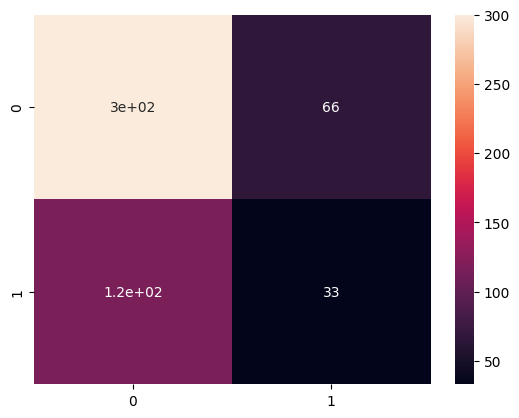

In [35]:
# Y is multiclass (Win, Draw, Loose): Y_alt is binary (Win)

y_train_alt = y_train[:, 0]
y_test_alt = y_test[:, 0]

xgb_win = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc")
xgb_win.fit(X_train_cut.reshape(X_train_cut.shape[0], -1), y_train_alt)

y_pred_alt = xgb_win.predict(X_test_cut.reshape(X_test_cut.shape[0], -1))

print(accuracy_score(y_test_alt, y_pred_alt), roc_auc_score(y_test_alt, y_pred_alt))

print(classification_report(y_test_alt, y_pred_alt))

cm = confusion_matrix(y_test_alt, y_pred_alt)
print(cm)
sns.heatmap(cm, annot=True)
plt.show()

Accuracy:  0.7377049180327869
ROC_AUC:  0.7377049180327868
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       366
           1       0.78      0.67      0.72       366

    accuracy                           0.74       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.74      0.74      0.74       732

[[296  70]
 [122 244]]


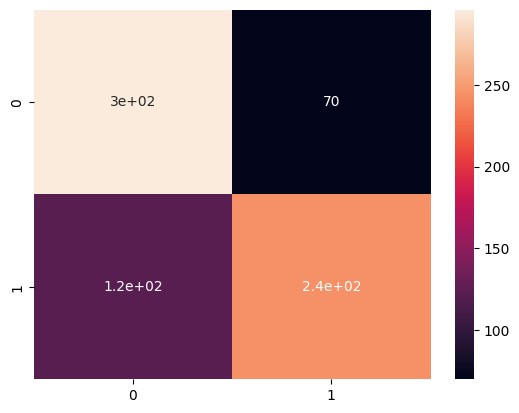

In [36]:
smote = SMOTE(sampling_strategy="auto")

X_train_cut_sm, y_train_alt_sm = smote.fit_resample(
    X_train_cut.reshape(X_train_cut.shape[0], -1), y_train_alt
)

X_test_cut_sm, y_test_alt_sm = smote.fit_resample(
    X_test_cut.reshape(X_test_cut.shape[0], -1), y_test_alt
)

xgb_win = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc")
xgb_win.fit(X_train_cut_sm, y_train_alt_sm)

y_pred_alt = xgb_win.predict(X_test_cut_sm)

print("Accuracy: ", accuracy_score(y_test_alt_sm, y_pred_alt))
print("ROC_AUC: ", roc_auc_score(y_test_alt_sm, y_pred_alt))
print(classification_report(y_test_alt_sm, y_pred_alt))
cm = confusion_matrix(y_test_alt_sm, y_pred_alt)
print(cm)

sns.heatmap(cm, annot=True)
plt.show()

<Axes: xlabel='importance', ylabel='feature'>

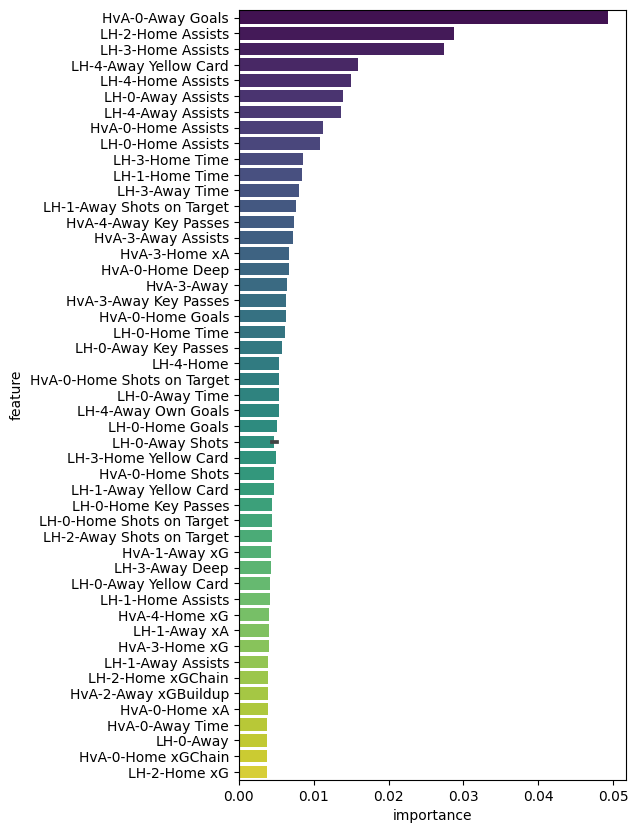

In [37]:
# First LAST_N are Home's team last five matches
# Second LAST_N are Aways's team last five matches
# Last LAST_N are last LAST_N Home-Away matches

X_cols_cut_3_LAST_N = [
    (f"LH-{i%LAST_N}-{col}" * (i < LAST_N))
    + (f"LH-{i%LAST_N}-{col}" * (i < LAST_N * 2 and i >= LAST_N))
    + (f"HvA-{i%LAST_N}-{col}" * (i >= LAST_N * 2))
    for i in range(3 * LAST_N)
    for col in X_cols_cut
]

# feature importance

feature_importance_gain = xgb_win.feature_importances_
labels = X_cols_cut_3_LAST_N

feature_importance_gainb_df = pd.DataFrame(
    {"feature": labels, "importance": feature_importance_gain}
).sort_values(by="importance", ascending=False)

fig, axs = plt.subplots(1, 1, figsize=(5, 10))

sns.barplot(
    x="importance", y="feature", data=feature_importance_gainb_df.head(50), palette="viridis", ax=axs
)

In [38]:
X_train_cut[:, 10:, :].shape

(2612, 5, 32)

In [39]:
# Only last HvA matches
X_train_cut_ha = X_train_cut[:, 10:, :].copy()
X_test_cut_ha = X_test_cut[:, 10:, :].copy()

X_cols = md_train[list(md_train.keys())[0]]["full_data"].columns
X_cols_cut = X_cols[2:36]
X_cols_cut = np.delete(X_cols_cut, [1, 3])
X_cols_cut

Index(['Home', 'Away', 'Home Goals', 'Away Goals', 'Home xG', 'Away xG',
       'Home Shots', 'Away Shots', 'Home Shots on Target',
       'Away Shots on Target', 'Home Deep', 'Away Deep', 'Away PPDA',
       'Home PPDA', 'Home Own Goals', 'Home Time', 'Home Yellow Card',
       'Home Red Card', 'Home Key Passes', 'Home Assists', 'Home xA',
       'Home xGChain', 'Home xGBuildup', 'Away Own Goals', 'Away Time',
       'Away Yellow Card', 'Away Red Card', 'Away Key Passes', 'Away Assists',
       'Away xA', 'Away xGChain', 'Away xGBuildup'],
      dtype='object')

Accuracy:  0.726775956284153
ROC_AUC:  0.7267759562841529
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       366
           1       0.73      0.71      0.72       366

    accuracy                           0.73       732
   macro avg       0.73      0.73      0.73       732
weighted avg       0.73      0.73      0.73       732

[[272  94]
 [106 260]]


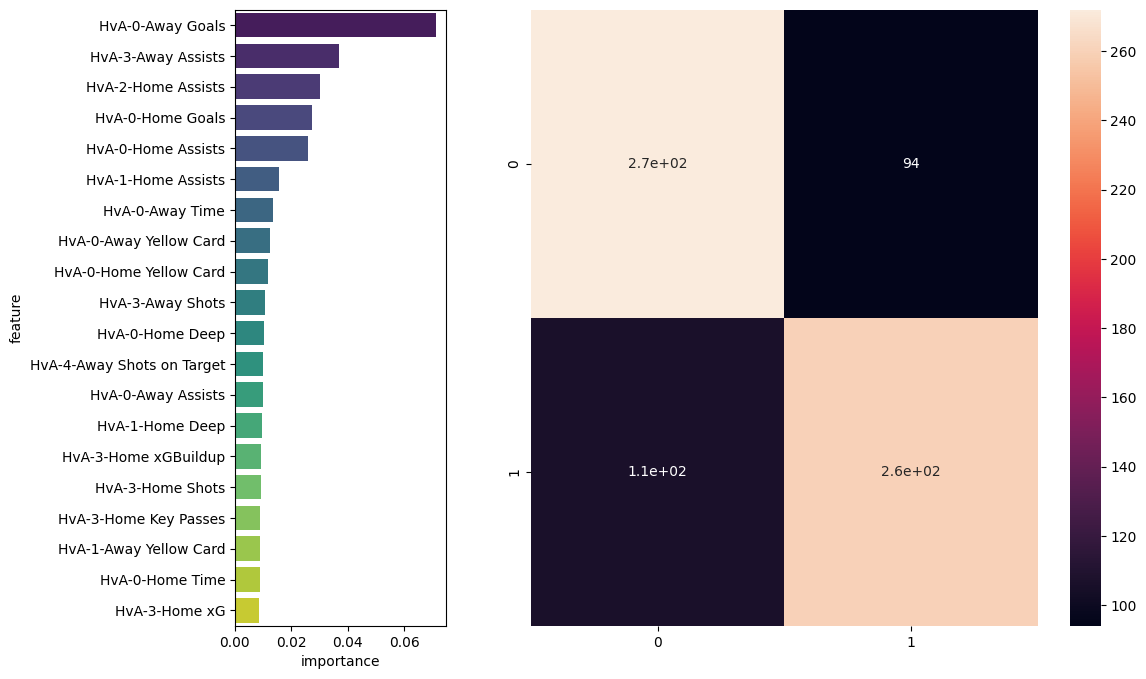

In [40]:
smote = SMOTE(sampling_strategy="auto")

X_train_cut_sm_ha, y_train_alt_sm_ha = smote.fit_resample(
    X_train_cut_ha.reshape(X_train_cut_ha.shape[0], -1), y_train_alt
)

X_test_cut_sm_ha, y_test_alt_sm_ha = smote.fit_resample(
    X_test_cut_ha.reshape(X_test_cut_ha.shape[0], -1), y_test_alt
)

xgb_win = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc")
xgb_win.fit(X_train_cut_sm_ha, y_train_alt_sm_ha)

y_pred_alt = xgb_win.predict(X_test_cut_sm_ha)

print("Accuracy: ", accuracy_score(y_test_alt_sm_ha, y_pred_alt))
print("ROC_AUC: ", roc_auc_score(y_test_alt_sm_ha, y_pred_alt))
print(classification_report(y_test_alt_sm_ha, y_pred_alt))
cm = confusion_matrix(y_test_alt_sm_ha, y_pred_alt)
print(cm)


feature_importance_gain = xgb_win.feature_importances_

X_cols_cut_3_LAST_N = [
    (f"LH-{i%LAST_N}-{col}" * (i < LAST_N))
    + (f"LH-{i%LAST_N}-{col}" * (i < LAST_N * 2 and i >= LAST_N))
    + (f"HvA-{i%LAST_N}-{col}" * (i >= LAST_N * 2))
    for i in range(3 * LAST_N)
    for col in X_cols_cut
]

labels = X_cols_cut_3_LAST_N[X_train_cut.shape[2] * 2 * LAST_N:]

feature_importance_gainb_df = pd.DataFrame(
    {"feature": labels, "importance": feature_importance_gain}
).sort_values(by="importance", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 8), width_ratios=[3, 9])

sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance_gainb_df.head(20),
    palette="viridis",
    ax=axs[0]
)

sns.heatmap(cm, annot=True, ax=axs[1])
plt.show()

In [41]:
X_cols_cut

Index(['Home', 'Away', 'Home Goals', 'Away Goals', 'Home xG', 'Away xG',
       'Home Shots', 'Away Shots', 'Home Shots on Target',
       'Away Shots on Target', 'Home Deep', 'Away Deep', 'Away PPDA',
       'Home PPDA', 'Home Own Goals', 'Home Time', 'Home Yellow Card',
       'Home Red Card', 'Home Key Passes', 'Home Assists', 'Home xA',
       'Home xGChain', 'Home xGBuildup', 'Away Own Goals', 'Away Time',
       'Away Yellow Card', 'Away Red Card', 'Away Key Passes', 'Away Assists',
       'Away xA', 'Away xGChain', 'Away xGBuildup'],
      dtype='object')

In [42]:
# Only last HvA matches

X_train_cut_ha = X_train_cut.copy()
X_test_cut_ha = X_test_cut.copy()
X_train_cut_ha = X_train_cut[:, 10:, :]
X_test_cut_ha = X_test_cut[:, 10:, :]

X_cols = md_train[list(md_train.keys())[0]]["full_data"].columns
X_cols_cut = X_cols[2:36]
X_cols_cut = np.delete(X_cols_cut, [1, 3])


X_cols_cut_3_LAST_N = [
    (f"LH-{i%LAST_N}-{col}" * (i < LAST_N))
    + (f"LH-{i%LAST_N}-{col}" * (i < LAST_N * 2 and i >= LAST_N))
    + (f"HvA-{i%LAST_N}-{col}" * (i >= LAST_N * 2))
    for i in range(3 * LAST_N)
    for col in X_cols_cut
]

labels = X_cols_cut_3_LAST_N
labels = labels[X_train_cut.shape[2] * 2 * LAST_N :]

# smote = SMOTE(sampling_strategy="auto")

# X_train_cut_sm_ha, y_train_alt_sm_ha = smote.fit_resample(
#     X_train_cut_ha.reshape(X_train_cut_ha.shape[0], -1), y_train_alt
# )

# X_test_cut_sm_ha, y_test_alt_sm_ha = smote.fit_resample(
#     X_test_cut_ha.reshape(X_test_cut_ha.shape[0], -1), y_test_alt
# )


# temp df for train and test using new labels to facilitate feature engeniering

# X_train_cut_sm_ha_df = pd.DataFrame(X_train_cut_sm_ha, columns = labels)
# X_train_cut_sm_ha_df

In [43]:
sk1 = [
    "Home",
    "Away",
    "Home Goals",
    "Away Goals",
    "Home xG",
    "Away xG",
    "Home Shots",
    "Away Shots",
    "Home Shots on Target",
    "Away Shots on Target",
]

sk2 = [
    "Home Key Passes",
    "Home Assists",
    "Home xA",
    "Away Key Passes",
    "Away Assists",
    "Away xA",
]

sk1 += sk2

# Keep only cols ending in sk1 items

X_train_mod = pd.DataFrame(X_train_cut_ha.reshape(X_train_cut_ha.shape[0], -1), columns = labels)
X_test_mod = pd.DataFrame(X_test_cut_ha.reshape(X_test_cut_ha.shape[0], -1), columns = labels)

subcols1 = [
    col for col in X_train_mod.columns for sk_col in sk1 if col.endswith(sk_col)
]

X_train_mod_sk1 = X_train_mod[subcols1]
X_test_mod_sk1 = X_test_mod[subcols1]

X_train_mod_sk1

,HvA-0-Home,HvA-0-Away,HvA-0-Home Goals,HvA-0-Away Goals,HvA-0-Home xG,HvA-0-Away xG,HvA-0-Home Shots,HvA-0-Away Shots,HvA-0-Home Shots on Target,HvA-0-Away Shots on Target,...,HvA-4-Home Shots,HvA-4-Away Shots,HvA-4-Home Shots on Target,HvA-4-Away Shots on Target,HvA-4-Home Key Passes,HvA-4-Home Assists,HvA-4-Home xA,HvA-4-Away Key Passes,HvA-4-Away Assists,HvA-4-Away xA
0,403,411,1.0,2.0,1.662618,1.935648,5.0,10.0,3,4,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,412,402,4.0,1.0,1.038595,0.417088,15.0,8.0,2,4,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,390,405,1.0,1.0,1.000597,0.682617,11.0,12.0,2,4,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,413,408,0.0,2.0,0.789519,1.542065,5.0,19.0,7,1,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,385,410,0.0,1.0,0.570954,2.389292,6.0,19.0,8,1,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,404,400,3.0,0.0,2.141466,0.161583,15.0,8.0,3,4,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2608,393,403,2.0,1.0,1.273065,0.710323,16.0,6.0,3,6,...,6.0,23.0,5,1,5.0,0.0,0.387671,15.0,1.0,0.601703
2609,411,410,0.0,0.0,0.723114,0.333754,15.0,5.0,3,4,...,8.0,20.0,2,1,7.0,0.0,0.825569,16.0,0.0,1.135025
2610,416,413,1.0,3.0,1.18776,1.782681,8.0,13.0,4,4,...,16.0,15.0,8,2,11.0,0.0,0.535771,10.0,2.0,1.799541


In [542]:
[col for col in X_cols_cut for sk_col in sk1 if col.endswith(sk_col)]

['Home',
 'Away',
 'Home Goals',
 'Away Goals',
 'Home xG',
 'Away xG',
 'Home Shots',
 'Away Shots',
 'Home Shots on Target',
 'Away Shots on Target',
 'Home Key Passes',
 'Home Assists',
 'Home xA',
 'Away Key Passes',
 'Away Assists',
 'Away xA']

In [543]:
pd.concat([X_train_mod_sk1, pd.DataFrame(y_train)], axis=1)

,HvA-0-Home,HvA-0-Away,HvA-0-Home Goals,HvA-0-Away Goals,HvA-0-Home xG,HvA-0-Away xG,HvA-0-Home Shots,HvA-0-Away Shots,HvA-0-Home Shots on Target,HvA-0-Away Shots on Target,...,HvA-4-Away Shots on Target,HvA-4-Home Key Passes,HvA-4-Home Assists,HvA-4-Home xA,HvA-4-Away Key Passes,HvA-4-Away Assists,HvA-4-Away xA,0,1,2
0,403,411,1.0,2.0,1.662618,1.935648,5.0,10.0,3,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,412,402,4.0,1.0,1.038595,0.417088,15.0,8.0,2,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,390,405,1.0,1.0,1.000597,0.682617,11.0,12.0,2,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,413,408,0.0,2.0,0.789519,1.542065,5.0,19.0,7,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4,385,410,0.0,1.0,0.570954,2.389292,6.0,19.0,8,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,404,400,3.0,0.0,2.141466,0.161583,15.0,8.0,3,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2608,393,403,2.0,1.0,1.273065,0.710323,16.0,6.0,3,6,...,1,5.0,0.0,0.387671,15.0,1.0,0.601703,0,0,1
2609,411,410,0.0,0.0,0.723114,0.333754,15.0,5.0,3,4,...,1,7.0,0.0,0.825569,16.0,0.0,1.135025,1,0,0
2610,416,413,1.0,3.0,1.18776,1.782681,8.0,13.0,4,4,...,2,11.0,0.0,0.535771,10.0,2.0,1.799541,0,0,1


In [44]:
X_train_mod_sk1.columns  # ['HvA-0-Home', 'HvA-0-Away', 'HvA-0-Home Goals', 'HvA-0-Away Goals',
#       'HvA-0-Home xG', 'HvA-0-Away xG', 'HvA-0-Home Shots',
#       'HvA-0-Away Shots', 'HvA-0-Home Shots on Target',
#       'HvA-0-Away Shots on Target', 'HvA-1-Home', 'HvA-1-Away',
#       'HvA-1-Home Goals', 'HvA-1-Away Goals', 'HvA-1-Home xG',
#       'HvA-1-Away xG', 'HvA-1-Home Shots', 'HvA-1-Away Shots',
#       'HvA-1-Home Shots on Target', 'HvA-1-Away Shots on Target',
#       'HvA-2-Home', 'HvA-2-Away', 'HvA-2-Home Goals', 'HvA-2-Away Goals',
#       'HvA-2-Home xG', 'HvA-2-Away xG', 'HvA-2-Home Shots',
#       'HvA-2-Away Shots', 'HvA-2-Home Shots on Target',
#       'HvA-2-Away Shots on Target', 'HvA-3-Home', 'HvA-3-Away',
#       'HvA-3-Home Goals', 'HvA-3-Away Goals', 'HvA-3-Home xG',
#       'HvA-3-Away xG', 'HvA-3-Home Shots', 'HvA-3-Away Shots',
#       'HvA-3-Home Shots on Target', 'HvA-3-Away Shots on Target',
#       'HvA-4-Home', 'HvA-4-Away', 'HvA-4-Home Goals', 'HvA-4-Away Goals',
#       'HvA-4-Home xG', 'HvA-4-Away xG', 'HvA-4-Home Shots',
#       'HvA-4-Away Shots', 'HvA-4-Home Shots on Target',
#       'HvA-4-Away Shots on Target']


col_sufixes = [col for col in X_cols_cut for sk_col in sk1 if col.endswith(sk_col)]
def reorder_home_away(X_df):
    X_df = X_df.copy()

    homes = X_df["HvA-0-Home"]
    aways = X_df["HvA-0-Away"]

    for i in range(1, LAST_N):
        col_group_home = X_df[f"HvA-{i}-Home"]

        for suf in col_sufixes[::2]:
            col_home = f"HvA-{i}-{suf}"
            col_away = f"HvA-{i}-{suf.replace('Home', 'Away')}"

            home_values = np.where(
                homes == col_group_home, X_df[col_home], X_df[col_away]
            )
            away_values = np.where(
                homes == col_group_home, X_df[col_away], X_df[col_home]
            )

            X_df.loc[:, col_home] = home_values
            X_df.loc[:, col_away] = away_values

    return X_df

X_train_ordered = reorder_home_away(X_train_mod_sk1)
X_test_ordered = reorder_home_away(X_test_mod_sk1)

y_train_wins = y_train[:, 0]
y_test_wins = y_test[:, 0]


pd.concat([
    X_train_ordered[[col for col in X_train_ordered.columns if type(col) == str and col.endswith("Home") and col.startswith("HvA")]], 
    X_train_ordered[[col for col in X_train_ordered.columns if type(col) == str and col.endswith("Away") and col.startswith("HvA")]], 
], axis=1)

,HvA-0-Home,HvA-1-Home,HvA-2-Home,HvA-3-Home,HvA-4-Home,HvA-0-Away,HvA-1-Away,HvA-2-Away,HvA-3-Away,HvA-4-Away
0,403,293,0,0,0,411,295,0,0,0
1,412,287,384,0,0,402,277,383,0,0
2,390,299,384,0,0,405,268,383,0,0
3,413,301,384,0,0,408,273,383,0,0
4,385,286,384,0,0,410,266,383,0,0
...,...,...,...,...,...,...,...,...,...,...
2607,404,367,384,0,0,400,347,383,0,0
2608,393,393,393,393,393,403,403,403,403,403
2609,411,411,411,411,411,410,410,410,410,410
2610,416,416,416,416,416,413,413,413,413,413


In [545]:
pd.concat([X_train_mod_sk1[[col for col in X_train_mod_sk1.columns if type(col) == str and col.endswith("Home")]], X_train_mod_sk1[[col for col in X_train_mod_sk1.columns if type(col) == str and col.endswith("Away")]]], axis=1).tail(10)

,HvA-0-Home,HvA-1-Home,HvA-2-Home,HvA-3-Home,HvA-4-Home,HvA-0-Away,HvA-1-Away,HvA-2-Away,HvA-3-Away,HvA-4-Away
2602,394,394,385,385,394,385,385,394,394,385
2603,417,417,390,61,383,390,390,417,80,384
2604,412,412,392,392,412,392,392,412,412,392
2605,414,414,397,57,383,397,397,414,73,384
2606,387,399,387,52,383,399,387,399,63,384
2607,404,45,383,0,0,400,69,384,0,0
2608,393,403,393,393,403,403,393,403,403,393
2609,411,411,410,411,410,410,410,411,410,411
2610,416,416,413,416,413,413,413,416,413,416
2611,402,415,402,51,383,415,402,415,67,384


In [546]:
X_train_ordered.values.shape, y_train_wins.shape, X_test_ordered.values.shape, y_train_wins.shape

((2612, 80), (2612,), (516, 80), (2612,))

In [547]:
col_sufixes

['Home',
 'Away',
 'Home Goals',
 'Away Goals',
 'Home xG',
 'Away xG',
 'Home Shots',
 'Away Shots',
 'Home Shots on Target',
 'Away Shots on Target',
 'Home Key Passes',
 'Home Assists',
 'Home xA',
 'Away Key Passes',
 'Away Assists',
 'Away xA']

In [548]:
X_train_ordered.columns[96:128], X_train_ordered.columns[200:232]

(Index([], dtype='object'), Index([], dtype='object'))

In [45]:
def cut_columns(X_df):
    
    # Cat LH-[3-4]-[col] and LA-[3-4]-[col]
    X_df = X_df.copy()

    if X_df.shape[1] != 3 * LAST_N * len(col_sufixes):
        return X_df
    for i in range(3, LAST_N):
        for suf in col_sufixes[::2]:
            col_home = f"LH-{i}-{suf}"
            col_away = f"LA-{i}-{suf}"

            X_df = X_df.drop(columns=[col_home, col_away])

    return X_df

X_train_ordered_cut = cut_columns(X_train_ordered)
X_test_ordered_cut = cut_columns(X_test_ordered)

X_train_ordered_cut.values.shape, y_train_wins.shape, X_test_ordered_cut.values.shape, y_train_wins.shape

((2612, 80), (2612,), (516, 80), (2612,))

In [46]:
def feature_engineering(X_df):
    X_df = X_df.copy()
    new_cols = {}

    for i in range(LAST_N):
        for suf in col_sufixes[::2]:
            col_home = f"HvA-{i}-{suf}"
            col_away = f"HvA-{i}-{suf.replace('Home', 'Away')}"

            #     # # Home Away diff
            #     # X_df[f"{col_home} - {col_away}"] = X_df[col_home] - X_df[col_away]

            #     # # Home Away diff ratio
            #     # # to catch division by zero: fill zeros with small number
            #     # X_df[f"{col_home} / {col_away}"] = X_df[col_home] / (X_df[col_away].replace(0, 1e-5))
            #     pass

            # fill nans with 0
            # X_df[col_home] = X_df[col_home].fillna(0)
            # X_df[col_away] = X_df[col_away].fillna(0)

            # fill nans with mean of previous i values
            # X_df[col_home] = X_df[col_home].fillna(X_df[col_home].rolling(i).mean())
            # X_df[col_away] = X_df[col_away].fillna(X_df[col_away].rolling(i).mean())

            # fill nans with mean of all values - Current Best
            # X_df[col_home] = X_df[col_home].fillna(X_df[col_home].mean())
            # X_df[col_away] = X_df[col_away].fillna(X_df[col_away].mean())


        # All cols Over xG
        for col in [
            # "Goals",
            # "Shots",
            "Shots on Target"
        ]:
            pass
            X_df[f"HvA-{i}-Home {col} / HvA-{i}-Home xG"] = X_df[f"HvA-{i}-Home {col}"] / X_df[f"HvA-{i}-Home xG"].replace(0, 1e-5)
            X_df[f"HvA-{i}-Away {col} / HvA-{i}-Away xG"] = X_df[f"HvA-{i}-Away {col}"] / X_df[f"HvA-{i}-Away xG"].replace(0, 1e-5)

            # new_cols[f"HvA-{i}-Home {col} / HvA-{i}-Home xG"] = X_df[f"HvA-{i}-Home {col}"] / X_df[f"HvA-{i}-Home xG"].replace(0, 1e-5)
            # new_cols[f"HvA-{i}-Away {col} / HvA-{i}-Away xG"] = X_df[f"HvA-{i}-Away {col}"] / X_df[f"HvA-{i}-Away xG"].replace(0, 1e-5)

        # Home Goals vs Away Goals
        # X_df[f"HvA-{i}-Home Goals - HvA-{i}-Away Goals"] = X_df[f"HvA-{i}-Home Goals"] - X_df[f"HvA-{i}-Away Goals"]
        # X_df[f"HvA-{i}-Home Goals / HvA-{i}-Away Goals"] = X_df[f"HvA-{i}-Home Goals"] / X_df[f"HvA-{i}-Away Goals"].replace(0, 1e-5)
        # Home Shots vs Away Shots
        # X_df[f"HvA-{i}-Home Shots - HvA-{i}-Away Shots"] = X_df[f"HvA-{i}-Home Shots"] - X_df[f"HvA-{i}-Away Shots"]
        # X_df[f"HvA-{i}-Home Shots / HvA-{i}-Away Shots"] = X_df[f"HvA-{i}-Home Shots"] / X_df[f"HvA-{i}-Away Shots"].replace(0, 1e-5)
        # Home Shots on Target vs Away Shots on Target
        # X_df[f"HvA-{i}-Home Shots on Target - HvA-{i}-Away Shots on Target"] = X_df[f"HvA-{i}-Home Shots on Target"] - X_df[f"HvA-{i}-Away Shots on Target"]
        # X_df[f"HvA-{i}-Home Shots on Target / HvA-{i}-Away Shots on Target"] = X_df[f"HvA-{i}-Home Shots on Target"] / X_df[f"HvA-{i}-Away Shots on Target"].replace(0, 1e-5)

        # # Shots on target ratio
        # X_df[f"HvA-{i}-Home Shots on Target / HvA-{i}-Home Shots"] = X_df[f"HvA-{i}-Home Shots on Target"] / X_df[f"HvA-{i}-Home Shots"].replace(0, 1e-5)
        # X_df[f"HvA-{i}-Away Shots on Target / HvA-{i}-Away Shots"] = X_df[f"HvA-{i}-Away Shots on Target"] / X_df[f"HvA-{i}-Away Shots"].replace(0, 1e-5)

        # # xG ratio
        # X_df[f"HvA-{i}-Home xG / HvA-{i}-Home Shots"] = X_df[f"HvA-{i}-Home xG"] / X_df[f"HvA-{i}-Home Shots"].replace(0, 1e-5)
        # X_df[f"HvA-{i}-Away xG / HvA-{i}-Away Shots"] = X_df[f"HvA-{i}-Away xG"] / X_df[f"HvA-{i}-Away Shots"].replace(0, 1e-5)

        # # Goals vs xG

        # # Diff

        # X_df[f"HvA-{i}-Home Goals - Home xG"] = X_df[f"HvA-{i}-Home Goals"] - X_df[f"HvA-{i}-Home xG"]
        # X_df[f"HvA-{i}-Away Goals - Away xG"] = X_df[f"HvA-{i}-Away Goals"] - X_df[f"HvA-{i}-Away xG"]

        # # Ratio

        # X_df[f"HvA-{i}-Home Goals / Home xG"] = X_df[f"HvA-{i}-Home Goals"] / X_df[f"HvA-{i}-Home xG"].replace(0, 1e-5)
        # X_df[f"HvA-{i}-Away Goals / Away xG"] = X_df[f"HvA-{i}-Away Goals"] / X_df[f"HvA-{i}-Away xG"].replace(0, 1e-5)

    # Ammount of Wins for The Home Team in last N matches
    # X_df["Home Wins"] = X_df[[col for col in X_df.columns if type(col) == str and col.endswith("Home Goals")]].sum(axis=1)
    # Ammount of Wins for The Away Team in last N matches
    # X_df["Away Wins"] = X_df[[col for col in X_df.columns if type(col) == str and col.endswith("Away Goals")]].sum(axis=1)    

    return pd.concat([X_df, pd.DataFrame(new_cols)], axis=1)

X_train_fe = feature_engineering(X_train_ordered_cut)
X_test_fe = feature_engineering(X_test_ordered_cut)

# leafve only HvA startin columns

X_train_fe = X_train_fe[[col for col in X_train_fe.columns if type(col) == str and col.startswith("HvA")]]

X_train_fe.shape, X_test_fe.shape, y_train_wins.shape, y_test_wins.shape

((2612, 90), (516, 90), (2612,), (516,))

In [569]:
X_train_fe.shape

(2612, 90)

In [47]:
# import cross val score

from sklearn.model_selection import cross_val_score

In [48]:
X_train_fe.shape

(2612, 90)

In [49]:
np.arange(X_train_fe.shape[1])[0]

0

In [50]:
X_train_fe.shape  # (2612, 90)

all_cols = np.arange(X_train_fe.shape[1])

X_train_fe.values[:, all_cols[:3]]

array([[403, 411, 1.0],
       [412, 402, 4.0],
       [390, 405, 1.0],
       ...,
       [411, 410, 0.0],
       [416, 413, 1.0],
       [402, 415, 0.0]], dtype=object)

In [51]:
from itertools import permutations

class AtributeSearch:
    def __init__(self, model, n_iter=100, cv=5, random=True, perms=False):
        self.model = model
        self.n_iter = n_iter
        self.cv = cv
        self.random = random
        self.perms = perms

    def fit(self, X, y):
        self.X = X
        self.y = y

        self.best_score_ = -np.inf
        self.best_cols_ = None
        self.best_estimator_ = self.model

        cols = np.arange(X.shape[1])

        if self.perms:
            # cols = np.random.permutation(X.columns)
            # compute all possible combinations (including or not each col)
            # cols = list(permutations(X.columns))
            # X is a numpy array

            cols = list(permutations(cols))

        print(
            f"Posible cols: {len(cols)} - CV: {self.cv} - Fit: {self.n_iter * self.cv}"
        )

        iterer = range(self.n_iter)
        for i in iterer:

            if self.random:
                # cols = np.random.choice(X.columns, np.random.randint(1, len(X.columns)), replace=False)
                cols = np.random.choice(cols, np.random.randint(1, len(cols)), replace=False)

            if self.perms:
                cols = cols[i]

            # score = np.mean(cross_val_score(self.model, X[:, cols], y, cv=self.cv, scoring="roc_auc"))
            score = roc_auc_score(y, self.model.fit(X[:, cols], y).predict(X[:, cols]))

            iterer.set_description(f"Score: {score:.4f} - Best Score: {self.best_score_:.4f}")

            if score > self.best_score_:
                self.best_score_ = score
                self.best_cols_ = cols
                self.best_estimator_ = self.model.fit(X[:, cols], y)

        return self

Accuracy:  0.7254098360655737
ROC_AUC:  0.7254098360655737
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       366
           1       0.74      0.69      0.72       366

    accuracy                           0.73       732
   macro avg       0.73      0.73      0.73       732
weighted avg       0.73      0.73      0.73       732

[[278  88]
 [113 253]]


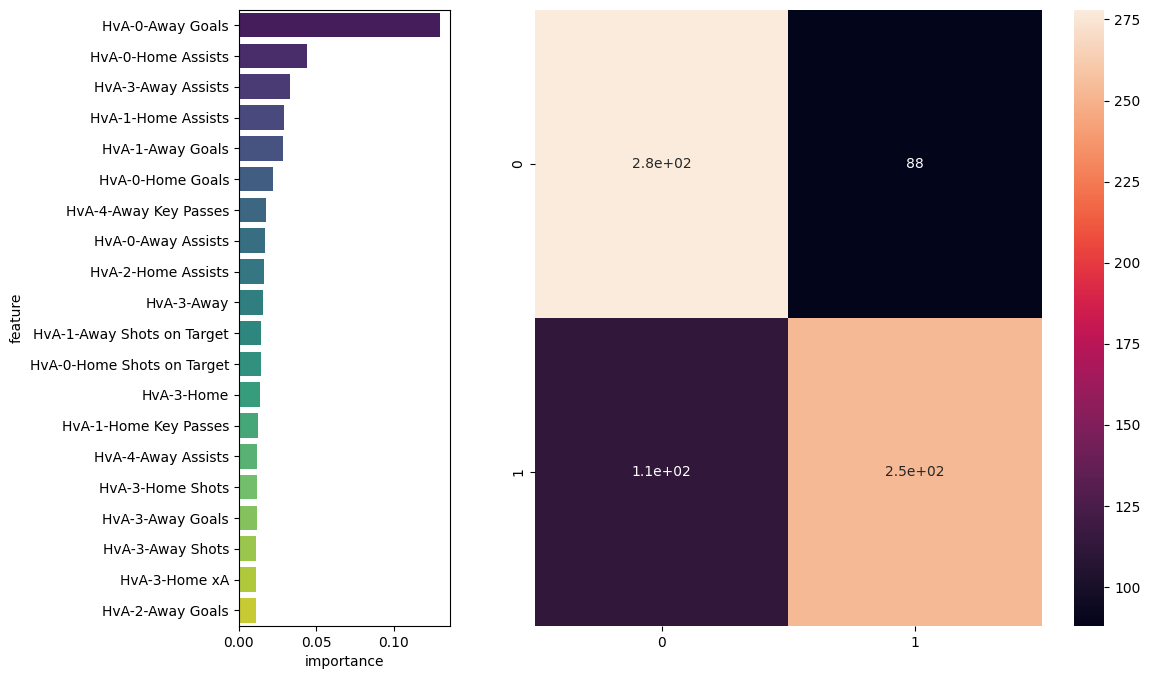

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, smote=False, random_search=False, attr_search=False):

    labels = X_train.columns
    X_train = X_train.values
    X_test = X_test.values    

    if smote:
        smote = SMOTE(sampling_strategy="auto", random_state=42)

        X_train, y_train = smote.fit_resample(X_train, y_train)
        X_test, y_test = smote.fit_resample(X_test, y_test)

    if random_search:
        # Randomized search
        param_space = {
            "max_depth": range(3, 100, 5),
            "eta": np.arange(0.1, 1.0, 0.1),
            "subsample": np.arange(0.5, 1.0, 0.1),
            "colsample_bytree": np.arange(0.5, 1.0, 0.1),
            "lambda": np.arange(0.1, 1.0, 0.1),
            "n_estimators": range(10, 500, 50),
        }

        # xgb_win = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", n_jobs=-1, verbosity=0)

        random_search = RandomizedSearchCV(
            xgb.XGBClassifier(
                objective="binary:logistic", eval_metric="auc", n_jobs=-1, verbosity=0
            ),
            param_space,
            n_iter=500,
            scoring="roc_auc",
            n_jobs=-1,
            cv=5,
            verbose=1,
            random_state=42,
        )

        random_search.fit(X_train, y_train)

        # Obtener los mejores parámetros
        best_params = random_search.best_params_
        print(best_params)

        # Entrenar el modelo con los mejores hiperparámetros
        xgb_win = random_search.best_estimator_
    
    
    if attr_search:

        model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", n_jobs=-1, verbosity=0)

        atribute_search = AtributeSearch(model, n_iter=100, cv=5, random=False, perms=True)

        atribute_search.fit(X_train, y_train)

        xgb_win = atribute_search.best_estimator_

    else:
        xgb_win = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", n_jobs=-1, verbosity=0)
        xgb_win.fit(X_train, y_train)
        

    y_pred = xgb_win.predict(X_test)

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("ROC_AUC: ", roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    feature_importance_gain = xgb_win.feature_importances_

    feature_importance_gainb_df = pd.DataFrame(
        {"feature": labels, "importance": feature_importance_gain}
    ).sort_values(by="importance", ascending=False)

    fig, axs = plt.subplots(1, 2, figsize=(12, 8), width_ratios=[3, 9])

    sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance_gainb_df.head(20),
    palette="viridis",
    ax=axs[0],
)

    sns.heatmap(cm, annot=True, ax=axs[1])
    plt.show()

    return xgb_win


# train_and_evaluate_xgb(X_train_mod_sk1, y_train_wins, X_test_mod_sk1, y_test_wins, smote=True)

train_and_evaluate_xgb(X_train_ordered, y_train_wins, X_test_ordered, y_test_wins, smote=True)

# train_and_evaluate_xgb(X_train_fe, y_train_wins, X_test_fe, y_test_wins, smote=True, random_search=True)

In [53]:
m1 = train_and_evaluate_xgb(
    X_train_fe, y_train_wins, X_test_fe, y_test_wins, smote=True, attr_search=True
)

: 

In [313]:
len(X_train_fe.columns)

90

<Axes: >

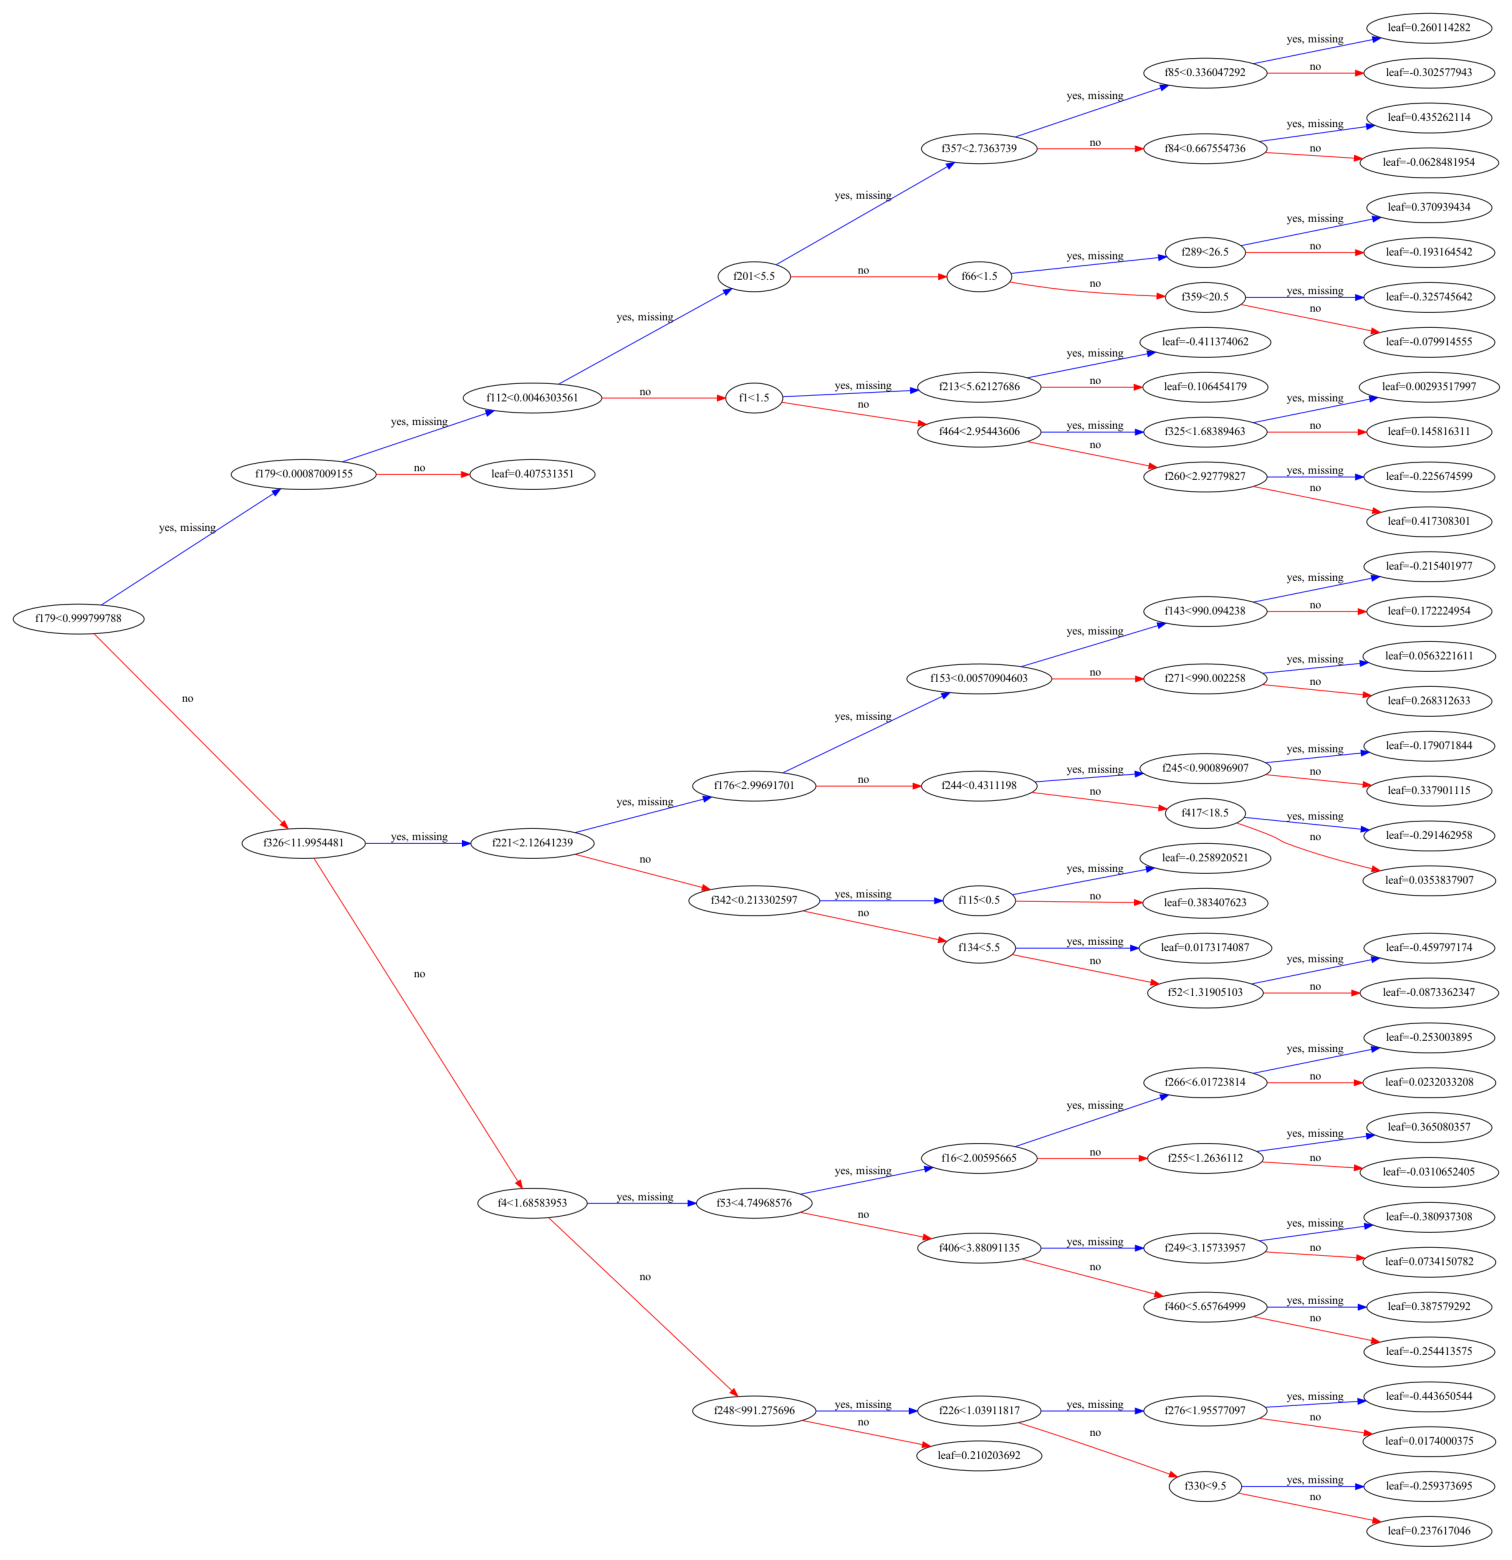

In [314]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(xgb_win, num_trees=4, ax=ax, rankdir="LR")

## HyperParam Tuning

In [ ]:
# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    "max_depth": [3, 5, 7],
    "eta": [0.1, 0.3, 0.5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "n_estimators": [50, 100, 200],
}

# Crear el modelo base
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=3, eval_metric="mlogloss", n_jobs=-1
)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, scoring="accuracy", cv=3, verbose=2
)

# Ajustar el modelo con los mejores hiperparámetros encontrados
grid_search.fit(X_train_cut.reshape(-1, 32 * 15), y_train.argmax(axis=1).reshape(-1))

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo con los mejores hiperparámetros
best_model_gs = grid_search.best_estimator_


# Predecir con el modelo
y_pred = best_model_gs.predict(X_test_cut.reshape(-1, 32 * 15))

# Imprimir el reporte de clasificación
print(classification_report(y_test.argmax(axis=1).reshape(-1), y_pred))

# Matriz de confusión
labels = ["Win", "Draw", "Lose"]
cm = confusion_matrix(y_test.argmax(axis=1).reshape(-1), y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    "max_depth": [3, 5, 7],
    "eta": [0.1, 0.3, 0.5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "n_estimators": [50, 100, 200],
}

# Crear el modelo base
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    nthread=4,
    eval_metric="mlogloss",
    n_jobs=-1,  # hist_method="gpu_hist"
)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=1,
)

# Ajustar el modelo con los mejores hiperparámetros encontrados
random_search.fit(X_train.reshape(-1, 32 * 15), y_train.argmax(axis=1).reshape(-1))

# Obtener los mejores parámetros
best_params = random_search.best_params_

# Entrenar el modelo con los mejores hiperparámetros
best_model_rs = random_search.best_estimator_

# Predecir con el modelo
y_pred = best_model_rs.predict(X_test.reshape(-1, 32 * 15))

# Imprimir el reporte de clasificación
print(classification_report(y_test.argmax(axis=1).reshape(-1), y_pred))

# Matriz de confusión
labels = ["Win", "Draw", "Lose"]
cm = confusion_matrix(y_test.argmax(axis=1).reshape(-1), y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
smote = SMOTE(sampling_strategy="auto")
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train.argmax(axis=1)
)

In [ ]:
rus = RandomUnderSampler(sampling_strategy="auto")
X_train_resampled_rus, y_train_resampled_rus = rus.fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train.argmax(axis=1)
)

In [ ]:
pd.Series(y_train.argmax(axis=1)).value_counts()

In [ ]:
pd.Series(y_test.argmax(axis=1)).value_counts()

In [ ]:
pd.Series(y_train_resampled_rus).value_counts()

In [ ]:
pd.Series(y_train_resampled_smote).value_counts()

In [ ]:
X_test_resampled_smote, y_test_resampled_smote = smote.fit_resample(X_test.reshape(X_test.shape[0], -1), y_test.argmax(axis=1))

pd.Series(y_test_resampled_smote).value_counts()

In [ ]:
X_test_resampled_rus, y_test_resampled_rus = RandomUnderSampler(sampling_strategy="auto").fit_resample(
    X_test.reshape(X_test.shape[0], -1), y_test.argmax(axis=1)
)

pd.Series(y_test_resampled_rus).value_counts()

In [ ]:
y_pred.shape, y_test_resampled_smote.shape

In [ ]:
X_test_resampled_smote.reshape(-1, 32 * 15).shape

In [ ]:
# SMOTE

# Train the model with the resampled data
xgb_model_imb = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    nthread=4,
    eval_metric="mlogloss",
    verbosity=1,
    n_jobs=-1,
)
xgb_model_imb.fit(X_train_resampled_smote, y_train_resampled_smote)

# Predecir con el modelo
y_pred = xgb_model_imb.predict(X_test_resampled_smote.reshape(-1, 32 * 15))

# Imprimir el reporte de clasificación
print(classification_report(y_test_resampled_smote, y_pred))

# Matriz de confusión
labels = ["Win", "Draw", "Lose"]
cm = confusion_matrix(y_test_resampled_smote, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el conjunto de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    "max_depth": range(3, 100, 5),
    "eta": np.arange(0.1, 1.0, 0.1),
    "subsample": np.arange(0.5, 1.0, 0.1),
    "colsample_bytree": np.arange(0.5, 1.0, 0.1),
    "lambda": np.arange(0.1, 1.0, 0.1),
    "n_estimators": range(10, 500, 50),
}

# Crear el modelo base
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    nthread=4,
    eval_metric="mlogloss",
    n_jobs=-1,  # hist_method="gpu_hist"
)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=500,
    scoring="accuracy",
    cv=3,
    verbose=1,
)

# Ajustar el modelo con los mejores hiperparámetros encontrados
random_search.fit(X_train_resampled_smote, y_train_resampled_smote)

# Obtener los mejores parámetros
best_params = random_search.best_params_

# Entrenar el modelo con los mejores hiperparámetros
best_model_rs = random_search.best_estimator_

# Predecir con el modelo
y_pred = best_model_rs.predict(X_test_resampled_smote.reshape(-1, 32 * 15))

# Imprimir el reporte de clasificación
print(classification_report(y_test_resampled_smote, y_pred))

# Matriz de confusión
labels = ["Win", "Draw", "Lose"]
cm = confusion_matrix(y_test_resampled_smote, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Save Data

In [ ]:
# save X, y to disk, as np arrays

os.makedirs("data", exist_ok=True)

np.save("data/X_train.npy", X_train)
np.save("data/y_train.npy", y_train)

np.save("data/X_test.npy", X_test)
np.save("data/y_test.npy", y_test)

In [ ]:
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).float()

X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).float()

## Torch Model

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(32 * 15, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 3),
    torch.nn.Sigmoid(),
    torch.nn.Softmax(dim=1)
)

model

In [ ]:
# X_train_t shape, y_train_t.shape
# (torch.Size([2612, 15, 32]), torch.Size([2612, 3]))

# join the last two dimensions of X_train_t
X_train_t = X_train_t.view(-1, 32*15)  # Change shape to (n_train_samples, 32*15)

# loss_fn = torch.nn.MSELoss(reduction="sum")

# softmax + cross entropy
loss_fn = torch.nn.CrossEntropyLoss()

# loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

epochs = 10000

loss_history = []

tqdm_iter = tqdm(range(epochs))
for t in tqdm_iter:
    y_pred = model(X_train_t)

    loss = loss_fn(y_pred, y_train_t)
    if t % 100 == 99:
        tqdm_iter.set_description(f"Loss: {loss.item()}")

    loss_history.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

# Asegurarse de que X_test_t tenga la forma correcta
X_test_t = X_test_t.view(-1, 32*15)  # Cambiar la forma a (n_test_samples, 32*15)

y_pred = model(X_test_t)


print(accuracy_score(y_test_t.argmax(dim=1), y_pred.argmax(dim=1)))

In [ ]:
# confusion matrix plot
# y_test_t.detach().numpy()[0]  # array([0., 0., 1.], dtype=float32)
# win, draw, lose

from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ["Win", "Draw", "Lose"]
cm = confusion_matrix(y_test_t.argmax(dim=1), y_pred.argmax(dim=1))

sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

In [ ]:
y_pred.argmax(dim=1)

In [ ]:
y_test_t.argmax(dim=1)

In [ ]:
y_pred.detach().numpy().ravel()

In [ ]:
y_test_t.detach().numpy().ravel()

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_test_t.detach().numpy().ravel(),
    y_pred.detach().numpy().ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(15, 32)),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, batch_size=32)

model.evaluate(X_test, y_test)